In [1]:
import torch
class ScaledConjugateGradient(torch.optim.Optimizer):
    def __init__(self, params, sigma=1e-4, lambda_=1e-6, lambdaHAT=0, N=10):
        params = list(params) 
        if len(params) == 0:
            raise ValueError("No parameters were passed to the optimizer.")
        defaults = {'sigma': sigma, 'lambda': lambda_, 'lambdaHAT': lambdaHAT, 'N': N}
        super(ScaledConjugateGradient, self).__init__(params, defaults)
        self.k = 1
        self.sigma = sigma
        self.N = sum(p.numel() for p in params)
        self.state = {}
        flattened_params = self.flattendTheModelParameters()
        self.state['rHat'] = torch.zeros_like(flattened_params)
        self.state['pHat'] = torch.zeros_like(flattened_params)
        self.state['lambda'] = lambda_
        self.state['lambdaHAT'] = lambdaHAT
        self.state['delta_k'] = 0
        self.state['success'] = True

    def flattendTheModelParameters(self):
        params = []
        for group in self.param_groups:
            for p in group['params']:
                if p.requires_grad:
                    params.append(p.view(-1))  
        return torch.cat(params) 

    def reshapeModelParams(self, flattened_params):
        offset = 0
        for group in self.param_groups:
            for p in group['params']:
                numel = p.numel() 
                p.data.copy_(flattened_params[offset:offset + numel].view_as(p))
                offset += numel

    def computeTheModelGradients(self, closure):
        loss = closure()
        flattened_grad = self.flattendTheModelGradients()
        return loss, flattened_grad

    def flattendTheModelGradients(self):
        grads = []
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    grads.append(p.grad.view(-1)) 
        return torch.cat(grads) 

    def step(self, closure=None):
        state = self.state
        N = self.N
        loss, grad = self.computeTheModelGradients(closure)
        state['rHat'].copy_(-grad)  
        state['pHat'].copy_(state['rHat'])
        pHat_norm = torch.norm(state['pHat'])
        if state['success'] == True:
            sigma_k = self.sigma / pHat_norm
            old_params = self.flattendTheModelParameters()
            new_params = self.flattendTheModelParameters() + sigma_k * state['pHat']
            self.reshapeModelParams(new_params)
            new_loss, new_grad = self.computeTheModelGradients(closure)
            self.reshapeModelParams(old_params)
            s_k = (new_grad - grad) / sigma_k
            delta_k = torch.dot(state['pHat'], s_k)
            state['delta_k'] = delta_k  
        state['delta_k'] = state['delta_k'] + (state['lambda'] - state['lambdaHAT']) * (pHat_norm**2)
        if state['delta_k'] <= 0:
            state['lambdaHAT'] = 2 * (state['lambda'] - (state['delta_k'] /pHat_norm**2))
            state['delta_k'] = -state['delta_k'] + state['lambda'] * pHat_norm**2
            state['lambda'] = state['lambdaHAT']
        mu_k = torch.dot(state['pHat'], state['rHat'])
        alpha_k = mu_k / state['delta_k'] + 1e-10
        old_params = self.flattendTheModelParameters()
        new_params = self.flattendTheModelParameters() + alpha_k * state['pHat']
        self.reshapeModelParams(new_params)
        new_loss, new_grad = self.computeTheModelGradients(closure)
        self.reshapeModelParams(old_params)
        delta_k_placeholder = 2 * state['delta_k'] * (loss - new_loss) / (mu_k**2)
        old_rHat = state['rHat']
        if delta_k_placeholder >= 0:
            self.reshapeModelParams(new_params)
            state['rHat'] = -new_grad
            state['lambdaHAT'] = 0
            state['success'] = True
            if self.k % N == 0:
                state['pHat'] = state['rHat']
            else:
                beta_k = (torch.norm(state['rHat'])**2 - torch.dot(state['rHat'], old_rHat))/mu_k
                state['pHat'] = state['rHat'] + beta_k*state['pHat']
            if delta_k_placeholder >= 0.75:
                state['lambda'] /= 4
        else:
            state['lambdaHAT'] = state['lambda']
            state['success'] = False
        if delta_k_placeholder < 0.25:
            state['lambda'] += (state['delta_k'] * (1 - delta_k_placeholder)/ pHat_norm**2)
        if torch.allclose(old_rHat, torch.zeros_like(old_rHat)):
            return loss
        else:
            self.k +=1

In [2]:
import numpy as np
import torch
import math
import torch.nn as nn

class LeapFrogOptimizer:
  def __init__(self, model, loss_function, dt, delta, epsilon, DeltaOne, m, max_iteration):
    self.model = model
    self.s = 1
    self.p = 1
    self.x = torch.cat([p.detach().clone().flatten() for p in model.parameters()])
    self.x_prev = self.x.clone() 
    self.x_next = self.x.clone() 
    self.a = torch.zeros(param_size)       
    self.x_next_next = self.x.clone() 
    self.loss_function = loss_function 
    self.k = -1
    self.dt = dt 
    self.a_next = torch.zeros(param_size) 
    self.delta = delta 
    self.epsilon = epsilon
    self.m = m 
    self.DeltaOne = DeltaOne
    self.max_iteration = max_iteration 
    self.v = torch.zeros(param_size)    
    self.i = 0
    self.j = 2
 
    param_size = self.x.size(0)
    self.v_prev = torch.zeros(param_size) 
    self.v_next = torch.zeros(param_size)

  def calculateGradientsofParams(self, X, y):
      self.model.zero_grad() 
      predictions = self.model(X) 
      loss = self.loss_function(predictions, y)
      loss.backward() 
      gradients = -torch.cat([p.grad.clone().flatten() for p in self.model.parameters()])

      return gradients

  def step(self, X, y):
    self.a = self.calculateGradientsofParams(X, y)
    self.v = 0.5 * self.a * self.dt

    while self.k < self.max_iteration:
      self.k += 1
      dx_norm = torch.norm(self.v) * self.dt
      if dx_norm < self.delta:                             
        self.p += self.DeltaOne 
        self.dt *= self.p
      else:
        self.v = (self.delta * self.v)/(self.dt * torch.norm(self.v))

      if self.s >= self.m:                                    
        self.dt /= 2 
        self.x = (self.x + self.x_prev)/2
        self.v = (self.v + self.v_prev)/4
        self.s = 0
      self.x_next = self.x + (self.v * self.dt)
             
      with torch.no_grad():
            predictions = self.model(X)
            current_loss = self.loss_function(predictions, y)
            print(f'Epoch {self.k}, Loss: {current_loss.item()}')
      while True:
        with torch.no_grad():
            start_idx = 0
            for param in self.model.parameters():
              param_size = param.numel()
              end_idx = start_idx + param_size
              param_values = self.x_next[start_idx:end_idx].reshape(param.shape)
              param.copy_(param_values)
              start_idx = end_idx
        self.a_next = self.calculateGradientsofParams(X, y)
        self.v_next = self.v + self.a_next * self.dt
        if torch.dot(self.a_next, self.a) > 0:
          self.s = 0
        else:
          self.s += 1
          self.p = 1

        if torch.norm(self.a_next) <= self.epsilon:
          print("Optimization converged.")
          return

        if torch.norm(self.v_next) > torch.norm(self.v):
          self.i = 0
          break
        else:
          self.x_next_next = (self.x_next + self.x)/2
          self.i += 1 

        if self.i <= self.j:
          self.v_next = (self.v_next + self.v)/4
          self.k += 1 
        else:
          self.v_next = torch.zeros_like(self.v)
          self.j = 1
          self.k += 1
        if torch.norm(self.v_next) > torch.norm(self.v):
          break
      
        self.x_prev = self.x.clone()
        self.x = self.x_next.clone()
        self.x_next = self.x_next_next.clone()
        self.v_prev = self.v.clone()
        self.v = self.v_next.clone()
        self.a = self.a_next.clone()
   
      self.x_prev = self.x.clone()
      self.x = self.x_next.clone()
      self.x_next = self.x_next_next.clone()
      self.v_prev = self.v.clone()
      self.v = self.v_next.clone()
      self.a = self.a_next.clone()

In [3]:
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix
import torch
import torch.nn as nn
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.datasets import load_digits  
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits  
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader

Using device: cuda
(1437, 64)
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Optimal parameters: {'hidden_size': 64, 'lr': 0.1}
Best accuracy score: 0.945677933177933
   param_hidden_size  param_lr  mean_test_score
0                 16       0.1         0.938020
1                 32       0.1         0.944308
2                 64       0.1         0.945678
3                128       0.1         0.938073
4                256       0.1         0.902535
Test set accuracy: 0.975
Confusion Matrix (Test Set):
[[36  0  0  0  0  0  0  0  0  0]
 [ 0 34  0  0  0  0  2  0  0  0]
 [ 0  0 35  0  0  0  0  0  0  0]
 [ 0  0  1 36  0  0  0  0  0  0]
 [ 0  0  0  0 35  0  1  0  0  0]
 [ 0  0  0  0  0 36  0  0  0  1]
 [ 0  0  0  0  0  0 35  0  1  0]
 [ 0  0  0  0  0  0  0 36  0  0]
 [ 0  2  0  0  0  0  0  0 33  0]
 [ 0  0  0  0  0  0  0  0  1 35]]


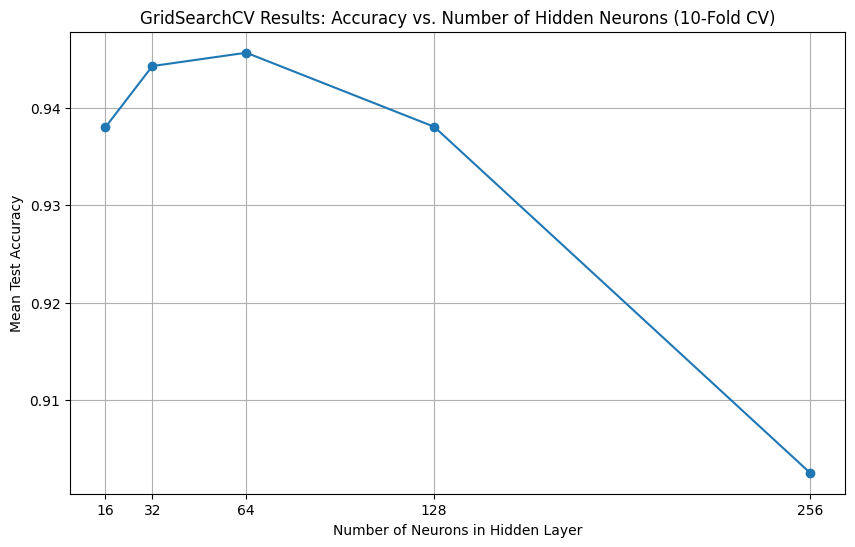

In [4]:





device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

np.random.seed(42)
torch.manual_seed(42)


digits = load_digits()
X_data = digits.data.astype(np.float32) / 16.0  
y_data = digits.target.astype(np.int64)  


X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

print(X_train.shape)

X_train_np = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
y_train_np = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train

X_test_np = X_test.to_numpy() if isinstance(X_test, pd.DataFrame) else X_test
y_test_np = y_test.to_numpy() if isinstance(y_test, pd.Series) else y_test


class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=10):  
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.hidden(x))  
        x = self.output(x)  
        return x


class PyTorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_size=784, hidden_size=1, output_size=10, epochs=5, batch_size=32, lr=0.01):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.device = device
        self.model = None  

    def fit(self, X, y):
        
        self.model = SimpleNN(self.input_size, self.hidden_size, self.output_size).to(self.device)
        
        
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.long).to(self.device)
        
        dataset = TensorDataset(X_tensor, y_tensor)  
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        optimizer = Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()  

        self.model.train()
        for epoch in range(self.epochs):
            for batch_x, batch_y in dataloader:
                optimizer.zero_grad()
                outputs = self.model(batch_x)  
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

        
        self.classes_ = np.unique(y)

        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            outputs = self.model(X_tensor)  
            predicted = torch.argmax(outputs, dim=1).cpu().numpy()  
            return predicted


param_grid = {
    'hidden_size': [16, 32, 64, 128, 256],  
    'lr': [0.1],                
}


from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=PyTorchClassifier(input_size=64, output_size=10, epochs=10, batch_size=256),  
    param_grid=param_grid,
    scoring='accuracy',
    cv=10, verbose=2, n_jobs=-1,
    error_score='raise'  
)


grid_search.fit(X_train_np, y_train_np)


optimal_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Optimal parameters: {optimal_params}")
print(f"Best accuracy score: {best_score}")


results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_hidden_size', 'param_lr', 'mean_test_score']])


best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test_np)
test_accuracy = accuracy_score(y_test_np, y_test_pred)

print(f"Test set accuracy: {test_accuracy}")


from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_np, y_test_pred)
print("Confusion Matrix (Test Set):")
print(conf_matrix)


plt.figure(figsize=(10, 6))
plt.plot(results_df['param_hidden_size'], results_df['mean_test_score'], marker='o', linestyle='-')
plt.title('GridSearchCV Results: Accuracy vs. Number of Hidden Neurons (10-Fold CV)')
plt.xlabel('Number of Neurons in Hidden Layer')
plt.ylabel('Mean Test Accuracy')
plt.xticks(results_df['param_hidden_size'])
plt.grid(True)
plt.show()

Using device: cuda
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Optimal parameters: {'lr': 0.05, 'momentum': 0.1}
Best cross-validation accuracy: 0.96659891598916
   param_lr  param_momentum  mean_test_score
0      0.01             0.1         0.960327
1      0.01             0.5         0.963110
2      0.01             0.9         0.966580
3      0.05             0.1         0.966599
4      0.05             0.5         0.956165
5      0.05             0.9         0.167741
6      0.10             0.1         0.947813
7      0.10             0.5         0.759950
8      0.10             0.9         0.100905
Test set accuracy: 0.9805555555555555
Confusion Matrix (Test Set):
[[35  0  0  0  1  0  0  0  0  0]
 [ 0 33  0  0  0  0  0  0  3  0]
 [ 0  0 35  0  0  0  0  0  0  0]
 [ 0  0  0 37  0  0  0  0  0  0]
 [ 0  0  0  0 36  0  0  0  0  0]
 [ 0  0  0  0  0 37  0  0  0  0]
 [ 0  0  0  0  0  0 35  0  1  0]
 [ 0  0  0  0  0  0  0 36  0  0]
 [ 0  2  0  0  0  0  0  0 33  0]
 [ 0  0 

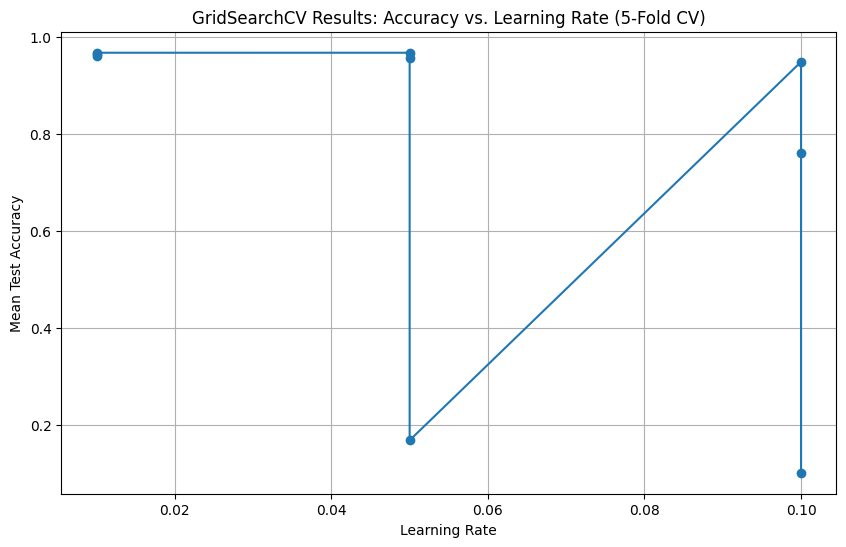

In [9]:
import torch
import torch.nn as nn
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.optim import SGD
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

np.random.seed(42)
torch.manual_seed(42)


digits = load_digits()
X_data = digits.data.astype(np.float32) / 16.0  
y_data = digits.target.astype(np.int64)  


X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42, stratify=y_data)



class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=10):  
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.hidden(x))  
        x = self.output(x)  
        return x


class PyTorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(
        self, input_size=784, hidden_size=128, output_size=10, epochs=10, batch_size=64, lr=0.01, momentum=0
    ):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.momentum = momentum
        self.device = device
        self.model = None  

    def fit(self, X, y):
        
        self.model = SimpleNN(self.input_size, self.hidden_size, self.output_size).to(self.device)
        dataset = TensorDataset(
            torch.tensor(X, dtype=torch.float32).to(self.device),
            torch.tensor(y, dtype=torch.long).to(self.device),  
        )
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        optimizer = SGD(self.model.parameters(), lr=self.lr, momentum=self.momentum)
        criterion = nn.CrossEntropyLoss()  

        self.model.train()
        for epoch in range(self.epochs):
            for batch_x, batch_y in dataloader:
                optimizer.zero_grad()
                outputs = self.model(batch_x)  
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

        
        self.classes_ = np.unique(y)

        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            outputs = self.model(X_tensor)  
            predicted = torch.argmax(outputs, dim=1).cpu().numpy()  
            return predicted


X_train_np = X_train if isinstance(X_train, np.ndarray) else X_train.to_numpy()
y_train_np = y_train if isinstance(y_train, np.ndarray) else y_train.to_numpy()


param_grid = {
    'lr': [0.01, 0.05, 0.1],       
    'momentum': [0.1, 0.5, 0.9],    
}


from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=PyTorchClassifier(input_size=64, hidden_size=64, output_size=10, epochs=10, batch_size=1),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    error_score='raise',  
    n_jobs=-1
)


grid_search.fit(X_train_np, y_train_np)


optimal_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Optimal parameters: {optimal_params}")
print(f"Best cross-validation accuracy: {best_score}")


results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_lr', 'param_momentum', 'mean_test_score']])


best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test set accuracy: {test_accuracy}")


from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Set):")
print(conf_matrix)


plt.figure(figsize=(10, 6))
plt.plot(results_df['param_lr'], results_df['mean_test_score'], marker='o', linestyle='-')
plt.title('GridSearchCV Results: Accuracy vs. Learning Rate (5-Fold CV)')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Test Accuracy')
plt.grid(True)
plt.show()


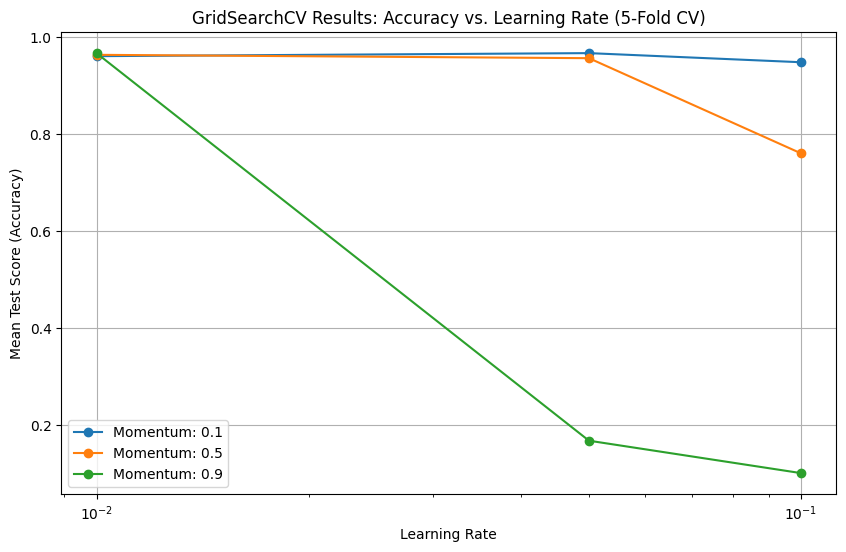

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

data_new = {
    'param_lr': [0.01, 0.01, 0.01, 0.05, 0.05, 0.05, 0.10, 0.10, 0.10],
    'param_momentum': [0.1, 0.5, 0.9, 0.1, 0.5, 0.9, 0.1, 0.5, 0.9],
    'mean_test_score': [0.960327, 0.963110, 0.966580, 0.966599, 0.956165, 0.167741, 0.947813, 0.759950, 0.100905]
}


results_df_new = pd.DataFrame(data_new)


plt.figure(figsize=(10, 6))
for momentum in [0.1, 0.5, 0.9]:
    subset = results_df_new[results_df_new['param_momentum'] == momentum]
    plt.plot(subset['param_lr'], subset['mean_test_score'], marker='o', linestyle='-', label=f'Momentum: {momentum}')


plt.title('GridSearchCV Results: Accuracy vs. Learning Rate (5-Fold CV)')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Test Score (Accuracy)')
plt.xscale('log')
plt.legend()
plt.grid(True)


plt.show()


Using device: cuda

Training fold 1/5...
Epoch 1/10, Training Loss: 0.800538
Epoch 2/10, Training Loss: 0.265266
Epoch 3/10, Training Loss: 0.176104
Epoch 4/10, Training Loss: 0.148274
Epoch 5/10, Training Loss: 0.114355
Epoch 6/10, Training Loss: 0.065205
Epoch 7/10, Training Loss: 0.069701
Epoch 8/10, Training Loss: 0.042573
Epoch 9/10, Training Loss: 0.039577
Epoch 10/10, Training Loss: 0.033553
Fold 1 - Test Accuracy: 0.9676, Training Time: 21.40 seconds

Training fold 2/5...
Epoch 1/10, Training Loss: 0.771644
Epoch 2/10, Training Loss: 0.221401
Epoch 3/10, Training Loss: 0.150491
Epoch 4/10, Training Loss: 0.103592
Epoch 5/10, Training Loss: 0.075839
Epoch 6/10, Training Loss: 0.056980
Epoch 7/10, Training Loss: 0.056377
Epoch 8/10, Training Loss: 0.041485
Epoch 9/10, Training Loss: 0.033244
Epoch 10/10, Training Loss: 0.019906
Fold 2 - Test Accuracy: 0.9537, Training Time: 18.05 seconds

Training fold 3/5...
Epoch 1/10, Training Loss: 0.795031
Epoch 2/10, Training Loss: 0.240686

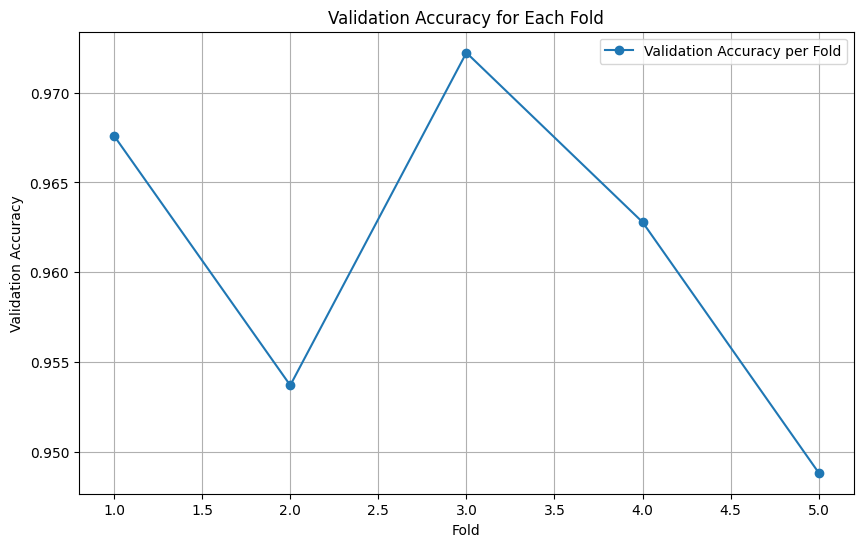

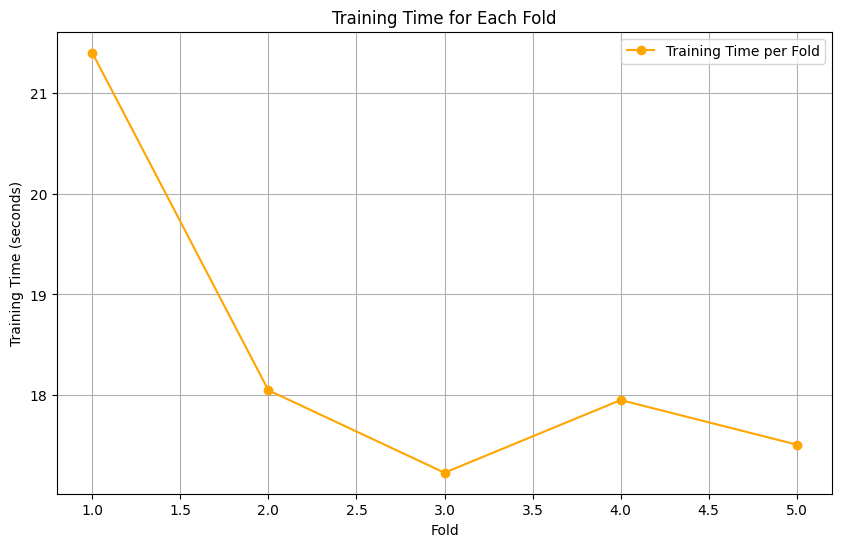

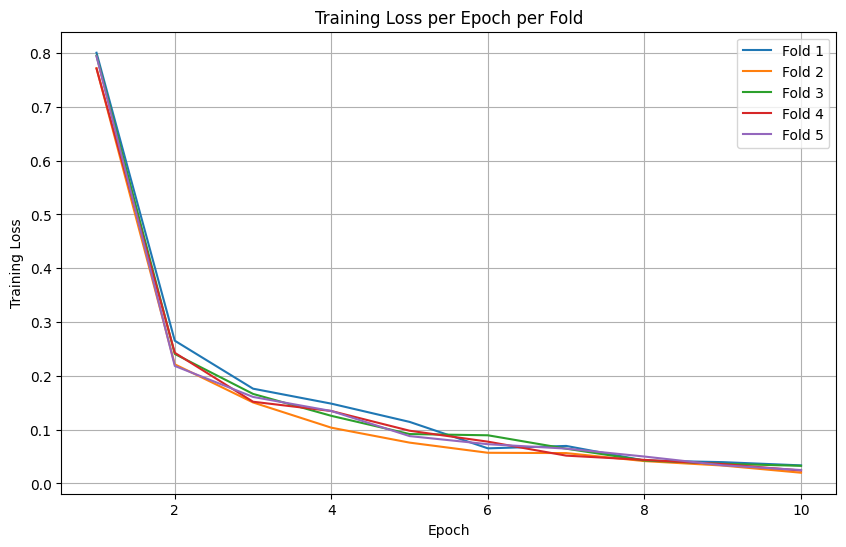

Epoch 1/5, Training Loss: 0.669848
Epoch 2/5, Training Loss: 0.204843
Epoch 3/5, Training Loss: 0.154231
Epoch 4/5, Training Loss: 0.114832
Epoch 5/5, Training Loss: 0.092900
Test set accuracy: 0.9708
Confusion Matrix (Test Set):
[[71  0  0  0  0  0  0  0  0  0]
 [ 0 66  0  1  0  0  0  0  6  0]
 [ 0  1 70  0  0  0  0  0  0  0]
 [ 0  0  0 73  0  0  0  0  0  0]
 [ 0  0  0  0 69  0  0  2  1  0]
 [ 0  0  1  0  0 69  0  0  0  3]
 [ 0  0  0  0  0  0 71  0  1  0]
 [ 0  0  0  1  0  0  0 70  1  0]
 [ 0  1  0  0  0  0  0  0 69  0]
 [ 0  0  0  1  0  0  0  0  1 70]]


In [11]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import time
from sklearn.base import BaseEstimator, ClassifierMixin


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

np.random.seed(42)
torch.manual_seed(42)



digits = load_digits()
X_data = digits.data.astype(np.float32) / 16.0  
y_data = digits.target.astype(np.int64)  


X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42, stratify=y_data)



from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.4, random_state=42, stratify=y_data)


class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=10):  
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.hidden(x))  
        x = self.output(x)             
        return x


class PyTorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_size=784, hidden_size=32, output_size=10, epochs=10, batch_size=1, lr=0.01):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.device = device
        self.model = None  

    def fit(self, X, y):
        
        self.model = SimpleNN(self.input_size, self.hidden_size, self.output_size).to(self.device)
        dataset = TensorDataset(torch.tensor(X, dtype=torch.float32).to(self.device),
                                torch.tensor(y, dtype=torch.long).to(self.device))  
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.1)
        criterion = nn.CrossEntropyLoss()  

        self.model.train()
        self.train_losses = []  
        for epoch in range(self.epochs):
            epoch_loss = 0.0
            for batch_x, batch_y in dataloader:
                optimizer.zero_grad()
                outputs = self.model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item() * batch_x.size(0)  
            epoch_loss /= len(dataset)  
            self.train_losses.append(epoch_loss)
            print(f"Epoch {epoch+1}/{self.epochs}, Training Loss: {epoch_loss:.6f}")
        
        
        self.classes_ = np.unique(y)
        
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            outputs = self.model(X_tensor)
            predicted = torch.argmax(outputs, dim=1).cpu().numpy()
            return predicted


def cross_validate_model(X, y, num_folds=10, epochs=5, batch_size=1, lr=0.05):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    fold_results = []
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nTraining fold {fold+1}/{num_folds}...")
        
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]

        
        model = PyTorchClassifier(input_size=64, hidden_size=64, output_size=10, epochs=epochs, batch_size=batch_size, lr=lr)

        
        start_time = time.time()

        
        model.fit(X_train_fold, y_train_fold)

        
        training_time = time.time() - start_time

        
        y_test_pred = model.predict(X_test_fold)
        test_accuracy = accuracy_score(y_test_fold, y_test_pred)

        
        fold_results.append({
            'fold': fold + 1,
            'test_accuracy': test_accuracy,
            'training_time': training_time,
            'train_losses': model.train_losses
        })

        print(f"Fold {fold+1} - Test Accuracy: {test_accuracy:.4f}, Training Time: {training_time:.2f} seconds")

    return fold_results


cross_val_results = cross_validate_model(
    X_train, y_train, num_folds=5, epochs=10, batch_size=1, lr=0.05
)


cross_val_df_sgd = pd.DataFrame(cross_val_results)
print("\nCross-Validation Results:")
print(cross_val_df_sgd[['fold', 'test_accuracy', 'training_time']])


val_accuracies = cross_val_df_sgd['test_accuracy']
plt.figure(figsize=(10,6))
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, marker='o', label='Validation Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Each Fold')
plt.grid(True)
plt.legend()
plt.show()


training_times = cross_val_df_sgd['training_time']
plt.figure(figsize=(10,6))
plt.plot(range(1, len(training_times)+1), training_times, marker='o', color='orange', label='Training Time per Fold')
plt.xlabel('Fold')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time for Each Fold')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(10,6))
for i, fold_result in enumerate(cross_val_results):
    train_losses = fold_result['train_losses']
    plt.plot(range(1, len(train_losses)+1), train_losses, label=f'Fold {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch per Fold')
plt.legend()
plt.grid(True)
plt.show()


final_model = PyTorchClassifier(input_size=64, hidden_size=64, output_size=10, epochs=5, batch_size=1, lr=0.05)
final_model.fit(X_train, y_train)


y_test_pred = final_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test set accuracy: {test_accuracy:.4f}")


from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Set):")
print(conf_matrix)

Using device: cpu

Training fold 1/5...
Epoch 1/10, Training Loss: 1.918699
Epoch 2/10, Training Loss: 1.634198
Epoch 3/10, Training Loss: 1.583281
Epoch 4/10, Training Loss: 0.777510
Epoch 5/10, Training Loss: 0.534652
Epoch 6/10, Training Loss: 0.480801
Epoch 7/10, Training Loss: 0.450423
Epoch 8/10, Training Loss: 0.426460
Epoch 9/10, Training Loss: 0.405870
Epoch 10/10, Training Loss: 0.387729
Fold 1 - Validation Accuracy: 0.9097, Training Time: 0.10 seconds

Training fold 2/5...
Epoch 1/10, Training Loss: 1.960360
Epoch 2/10, Training Loss: 1.682199
Epoch 3/10, Training Loss: 1.539308
Epoch 4/10, Training Loss: 1.140979
Epoch 5/10, Training Loss: 0.975949
Epoch 6/10, Training Loss: 0.873038
Epoch 7/10, Training Loss: 0.792643
Epoch 8/10, Training Loss: 0.725544
Epoch 9/10, Training Loss: 0.666541
Epoch 10/10, Training Loss: 0.616324
Fold 2 - Validation Accuracy: 0.9097, Training Time: 0.07 seconds

Training fold 3/5...
Epoch 1/10, Training Loss: 1.900450
Epoch 2/10, Training Loss:

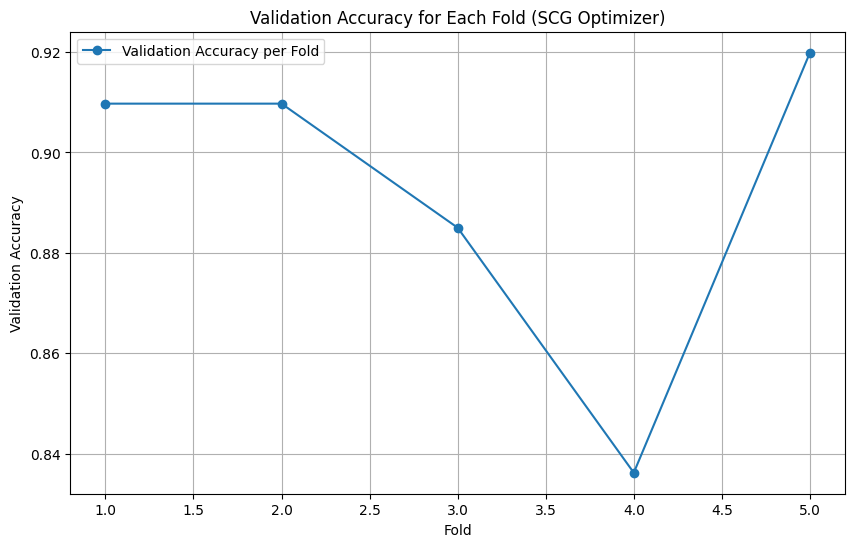

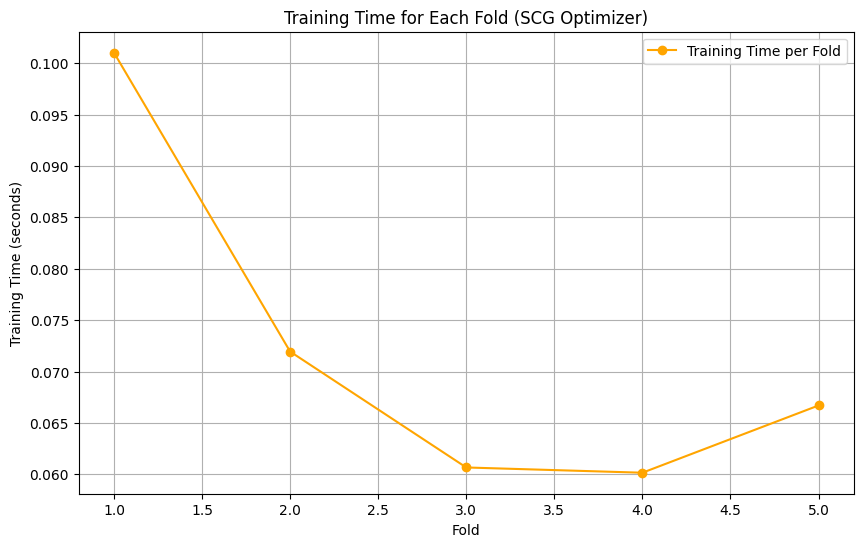

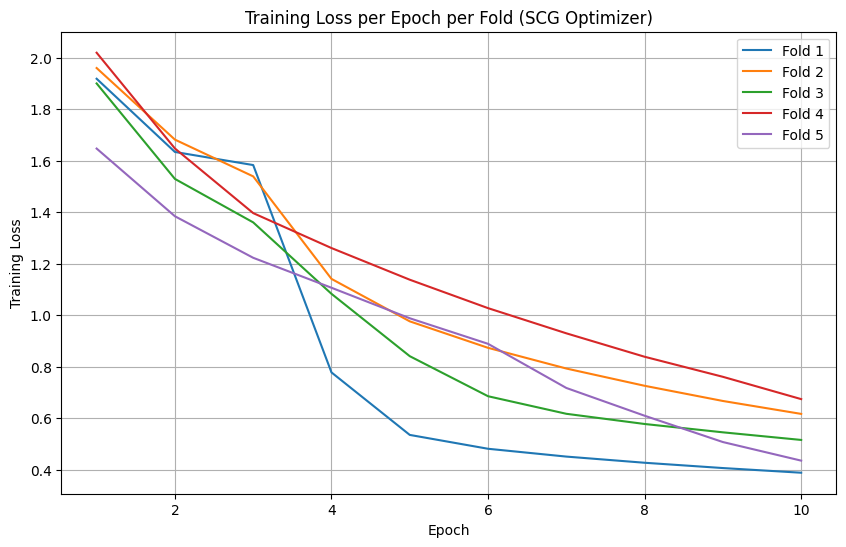

Epoch 1/5, Training Loss: 1.680962
Epoch 2/5, Training Loss: 1.326570
Epoch 3/5, Training Loss: 1.177962
Epoch 4/5, Training Loss: 1.054939
Epoch 5/5, Training Loss: 0.950723
Test set accuracy: 0.8667
Confusion Matrix (Test Set):
[[35  0  0  0  1  0  0  0  0  0]
 [ 0 25  3  0  0  2  1  0  0  5]
 [ 1  1 33  0  0  0  0  0  0  0]
 [ 0  0  0 35  0  0  0  1  0  1]
 [ 0  3  0  0 33  0  0  0  0  0]
 [ 0  0  0  0  0 33  0  0  0  4]
 [ 0  1  0  0  0  0 34  0  1  0]
 [ 0  0  0  0  0  0  0 36  0  0]
 [ 0  8  3  3  0  4  0  1 14  2]
 [ 0  0  0  0  0  0  0  1  1 34]]


In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import time
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris





device = torch.device("cpu")
print(f"Using device: {device}")

np.random.seed(42)
torch.manual_seed(42)


digits = load_digits()
X_data = digits.data.astype(np.float32) / 16.0  
y_data = digits.target.astype(np.int64)  


X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42, stratify=y_data)




class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=10):  
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.hidden(x))  
        x = self.output(x)             
        return x


class PyTorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_size=64, hidden_size=64, output_size=10, epochs=5):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.epochs = epochs
        self.device = device
        self.model = None  

    def fit(self, X, y):
        
        self.model = SimpleNN(self.input_size, self.hidden_size, self.output_size).to(self.device)
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.long).to(self.device)

        criterion = nn.CrossEntropyLoss()  

        self.model.train()
        self.train_losses = []  

        
        def closure():
            optimizer.zero_grad()
            outputs = self.model(X_tensor)
            loss = criterion(outputs, y_tensor)
            loss.backward()
            return loss

        
        optimizer = ScaledConjugateGradient(self.model.parameters())

        for epoch in range(self.epochs):
            loss = optimizer.step(closure)
            train_loss = criterion(self.model(X_tensor), y_tensor).item()
            self.train_losses.append(train_loss)
            print(f"Epoch {epoch+1}/{self.epochs}, Training Loss: {train_loss:.6f}")

        
        self.classes_ = np.unique(y)

        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            outputs = self.model(X_tensor)  
            predicted = torch.argmax(outputs, dim=1).cpu().numpy()  
            return predicted


import time


def cross_validate_model(X, y, num_folds=5, epochs=5):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    fold_results = []
    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        print(f"\nTraining fold {fold+1}/{num_folds}...")
        
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        
        model = PyTorchClassifier(input_size=64, hidden_size=64, epochs=epochs)

        
        start_time = time.time()

        
        model.fit(X_train_fold, y_train_fold)

        
        training_time = time.time() - start_time

        
        y_val_pred = model.predict(X_val_fold)
        val_accuracy = accuracy_score(y_val_fold, y_val_pred)

        
        fold_results.append({
            'fold': fold + 1,
            'val_accuracy': val_accuracy,
            'training_time': training_time,
            'train_losses': model.train_losses
        })

        print(f"Fold {fold+1} - Validation Accuracy: {val_accuracy:.4f}, Training Time: {training_time:.2f} seconds")

    return fold_results


cross_val_results = cross_validate_model(
    X_train, y_train, num_folds=5, epochs=10
)


cross_val_df_scg = pd.DataFrame(cross_val_results)
print("\nCross-Validation Results:")
print(cross_val_df_scg[['fold', 'val_accuracy', 'training_time']])


val_accuracies = cross_val_df_scg['val_accuracy']
plt.figure(figsize=(10,6))
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, marker='o', label='Validation Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Each Fold (SCG Optimizer)')
plt.grid(True)
plt.legend()
plt.show()


training_times = cross_val_df_scg['training_time']
plt.figure(figsize=(10,6))
plt.plot(range(1, len(training_times)+1), training_times, marker='o', color='orange', label='Training Time per Fold')
plt.xlabel('Fold')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time for Each Fold (SCG Optimizer)')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(10,6))
for i, fold_result in enumerate(cross_val_results):
    train_losses = fold_result['train_losses']
    plt.plot(range(1, len(train_losses)+1), train_losses, label=f'Fold {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch per Fold (SCG Optimizer)')
plt.legend()
plt.grid(True)
plt.show()


final_model = PyTorchClassifier(input_size=64, hidden_size=64, epochs=5)
final_model.fit(X_train, y_train)

y_test_pred = final_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test set accuracy: {test_accuracy:.4f}")


from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Set):")
print(conf_matrix)


Using device: cuda

Training fold 1/5...
Epoch 0, Loss: 2.3259329795837402
Epoch 1, Loss: 2.3058290481567383
Epoch 2, Loss: 2.234503984451294
Epoch 3, Loss: 2.0908284187316895
Epoch 4, Loss: 1.806219220161438
Epoch 5, Loss: 1.4468631744384766
Epoch 6, Loss: 1.1122572422027588
Epoch 7, Loss: 0.8376346826553345
Epoch 8, Loss: 0.6266090273857117
Epoch 9, Loss: 0.4719094932079315
Epoch 10, Loss: 0.3677167594432831
Epoch 1/10, Training Loss: 0.284861
Epoch 2/10, Training Loss: 0.284861
Epoch 3/10, Training Loss: 0.284861
Epoch 4/10, Training Loss: 0.284861
Epoch 5/10, Training Loss: 0.284861
Epoch 6/10, Training Loss: 0.284861
Epoch 7/10, Training Loss: 0.284861
Epoch 8/10, Training Loss: 0.284861
Epoch 9/10, Training Loss: 0.284861
Epoch 10/10, Training Loss: 0.284861
Fold 1 - Validation Accuracy: 0.9201, Training Time: 0.49 seconds

Training fold 2/5...
Epoch 0, Loss: 2.3015830516815186
Epoch 1, Loss: 2.282892942428589
Epoch 2, Loss: 2.216797113418579
Epoch 3, Loss: 2.0822582244873047
Epo

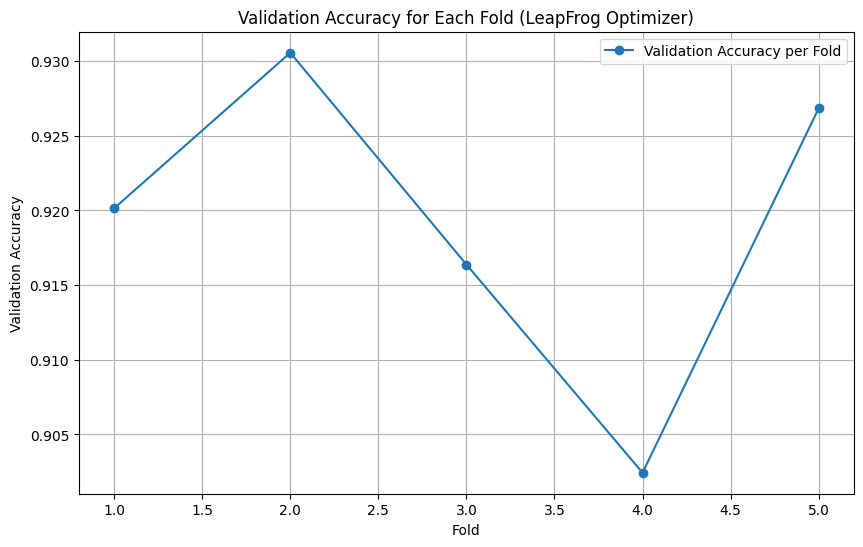

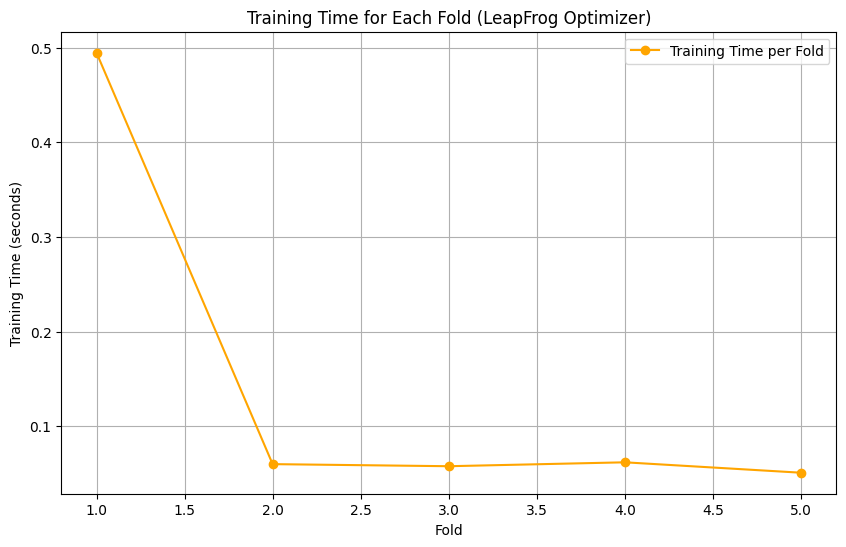

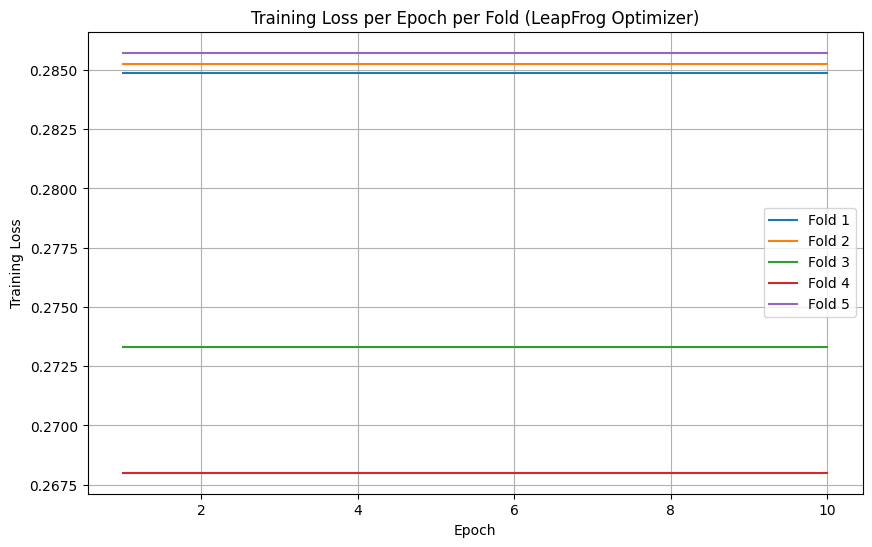

Epoch 0, Loss: 2.307687759399414
Epoch 1, Loss: 2.291116237640381
Epoch 2, Loss: 2.229736089706421
Epoch 3, Loss: 2.0936036109924316
Epoch 4, Loss: 1.7996068000793457
Epoch 5, Loss: 1.4457621574401855
Epoch 6, Loss: 1.1034084558486938
Epoch 7, Loss: 0.813060998916626
Epoch 8, Loss: 0.595920979976654
Epoch 9, Loss: 0.44610583782196045
Epoch 10, Loss: 0.34184953570365906
Epoch 1/10, Training Loss: 0.269963
Epoch 2/10, Training Loss: 0.269963
Epoch 3/10, Training Loss: 0.269963
Epoch 4/10, Training Loss: 0.269963
Epoch 5/10, Training Loss: 0.269963
Epoch 6/10, Training Loss: 0.269963
Epoch 7/10, Training Loss: 0.269963
Epoch 8/10, Training Loss: 0.269963
Epoch 9/10, Training Loss: 0.269963
Epoch 10/10, Training Loss: 0.269963
Test set accuracy: 0.9111
Confusion Matrix (Test Set):
[[35  0  0  0  1  0  0  0  0  0]
 [ 0 24  3  0  0  1  2  0  1  5]
 [ 0  1 34  0  0  0  0  0  0  0]
 [ 0  0  1 36  0  0  0  0  0  0]
 [ 0  0  0  0 36  0  0  0  0  0]
 [ 0  0  0  0  0 36  0  0  0  1]
 [ 0  0  0  0 

In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import time
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

np.random.seed(42)
torch.manual_seed(42)


digits = load_digits()
X_data = digits.data.astype(np.float32) / 16.0  
y_data = digits.target.astype(np.int64)  


X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42, stratify=y_data)




class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=10):  
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.hidden(x))  
        x = self.output(x)             
        return x


class PyTorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_size=64, hidden_size=64, output_size=10, epochs=5):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.epochs = epochs
        self.device = device
        self.model = None  

    def fit(self, X, y):
        
        self.model = SimpleNN(self.input_size, self.hidden_size, self.output_size).to(self.device)
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.long).to(self.device)

        criterion = nn.CrossEntropyLoss()  

        self.model.train()
        self.train_losses = []  

        
        optimizer = LeapFrogOptimizer(
            self.model, criterion, dt=0.5, delta=1, epsilon=1e-7, delta1=0.1, m=3, max_iteration=self.epochs
        )

        
        start_time = time.time()

        
        for epoch in range(self.epochs):
            
            optimizer.step(X_tensor, y_tensor)

            
            outputs = self.model(X_tensor)
            loss = criterion(outputs, y_tensor)
            train_loss = loss.item()
            self.train_losses.append(train_loss)

            print(f"Epoch {epoch+1}/{self.epochs}, Training Loss: {train_loss:.6f}")

        
        training_time = time.time() - start_time
        self.training_time = training_time

        
        self.classes_ = np.unique(y)

        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            outputs = self.model(X_tensor)  
            predicted = torch.argmax(outputs, dim=1).cpu().numpy()  
            return predicted




import time


def cross_validate_model(X, y, num_folds=5, epochs=5):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    fold_results = []
    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        print(f"\nTraining fold {fold+1}/{num_folds}...")
        
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        
        model = PyTorchClassifier(input_size=64, hidden_size=64, epochs=epochs)

        
        start_time = time.time()

        
        model.fit(X_train_fold, y_train_fold)

        
        training_time = time.time() - start_time

        
        y_val_pred = model.predict(X_val_fold)
        val_accuracy = accuracy_score(y_val_fold, y_val_pred)

        
        fold_results.append({
            'fold': fold + 1,
            'val_accuracy': val_accuracy,
            'training_time': training_time,
            'train_losses': model.train_losses
        })

        print(f"Fold {fold+1} - Validation Accuracy: {val_accuracy:.4f}, Training Time: {training_time:.2f} seconds")

    return fold_results


cross_val_results = cross_validate_model(
    X_train, y_train, num_folds=5, epochs=10
)



cross_val_df_leapFrog = pd.DataFrame(cross_val_results)
print("\nCross-Validation Results:")
print(cross_val_df_leapFrog[['fold', 'val_accuracy', 'training_time']])


val_accuracies = cross_val_df_leapFrog['val_accuracy']
plt.figure(figsize=(10,6))
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, marker='o', label='Validation Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Each Fold (LeapFrog Optimizer)')
plt.grid(True)
plt.legend()
plt.show()


training_times = cross_val_df_leapFrog['training_time']
plt.figure(figsize=(10,6))
plt.plot(range(1, len(training_times)+1), training_times, marker='o', color='orange', label='Training Time per Fold')
plt.xlabel('Fold')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time for Each Fold (LeapFrog Optimizer)')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(10,6))
for i, fold_result in enumerate(cross_val_results):
    train_losses = fold_result['train_losses']
    plt.plot(range(1, len(train_losses)+1), train_losses, label=f'Fold {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch per Fold (LeapFrog Optimizer)')
plt.legend()
plt.grid(True)
plt.show()


final_model = PyTorchClassifier(input_size=64, hidden_size=64, epochs=10)
final_model.fit(X_train, y_train)

y_test_pred = final_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test set accuracy: {test_accuracy:.4f}")


from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Set):")
print(conf_matrix)


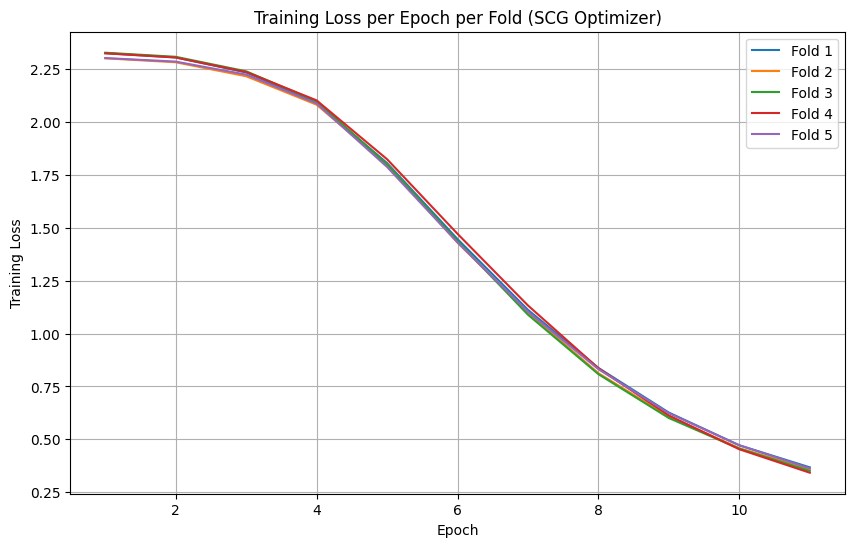

In [7]:
import pandas as pd
import re

def parse_training_log_no_nan(log_str):
    
    fold_pattern = re.compile(r"Training fold (\d+)/\d+...")
    epoch_loss_pattern = re.compile(r"Epoch (\d+), Loss: ([\d.]+)")
    
    
    results = {}
    
    current_fold = None
    max_epochs = 0  

    for line in log_str.splitlines():
        fold_match = fold_pattern.match(line)
        if fold_match:
            current_fold = int(fold_match.group(1))
            results[current_fold] = {}
        elif current_fold is not None:
            epoch_loss_match = epoch_loss_pattern.match(line)
            if epoch_loss_match:
                epoch = int(epoch_loss_match.group(1))
                loss = float(epoch_loss_match.group(2))
                results[current_fold][epoch] = loss
                max_epochs = max(max_epochs, epoch)
    
    
    for fold in results:
        last_loss = None
        for epoch in range(max_epochs + 1):
            if epoch in results[fold]:
                last_loss = results[fold][epoch]
            else:
                results[fold][epoch] = last_loss  
    
    
    df = pd.DataFrame.from_dict(results, orient='index').transpose()
    return df






log_str = """Training fold 1/5...
Epoch 0, Loss: 2.3259329795837402
Epoch 1, Loss: 2.3058290481567383
Epoch 2, Loss: 2.234503984451294
Epoch 3, Loss: 2.0908284187316895
Epoch 4, Loss: 1.806219220161438
Epoch 5, Loss: 1.4468631744384766
Epoch 6, Loss: 1.1122572422027588
Epoch 7, Loss: 0.8376346826553345
Epoch 8, Loss: 0.6266090273857117
Epoch 9, Loss: 0.4719094932079315
Epoch 10, Loss: 0.3677167594432831
Fold 1 - Validation Accuracy: 0.9201, Training Time: 0.49 seconds

Training fold 2/5...
Epoch 0, Loss: 2.3015830516815186
Epoch 1, Loss: 2.282892942428589
Epoch 2, Loss: 2.216797113418579
Epoch 3, Loss: 2.0822582244873047
Epoch 4, Loss: 1.7992955446243286
Epoch 5, Loss: 1.430627465248108
Epoch 6, Loss: 1.0985379219055176
Epoch 7, Loss: 0.8127641081809998
Epoch 8, Loss: 0.6081240177154541
Epoch 9, Loss: 0.4581511318683624
Epoch 10, Loss: 0.3592176139354706
Fold 2 - Validation Accuracy: 0.9306, Training Time: 0.06 seconds

Training fold 3/5...
Epoch 0, Loss: 2.3280086517333984
Epoch 1, Loss: 2.3087258338928223
Epoch 2, Loss: 2.240133762359619
Epoch 3, Loss: 2.0978479385375977
Epoch 4, Loss: 1.799704909324646
Epoch 5, Loss: 1.4376113414764404
Epoch 6, Loss: 1.089154839515686
Epoch 7, Loss: 0.8081740736961365
Epoch 8, Loss: 0.6008777618408203
Epoch 9, Loss: 0.455782949924469
Epoch 10, Loss: 0.35076335072517395
Fold 3 - Validation Accuracy: 0.9164, Training Time: 0.06 seconds

Training fold 4/5...
Epoch 0, Loss: 2.3251824378967285
Epoch 1, Loss: 2.3053841590881348
Epoch 2, Loss: 2.2371468544006348
Epoch 3, Loss: 2.10268497467041
Epoch 4, Loss: 1.824471354484558
Epoch 5, Loss: 1.4717354774475098
Epoch 6, Loss: 1.132983684539795
Epoch 7, Loss: 0.8362160921096802
Epoch 8, Loss: 0.6129592657089233
Epoch 9, Loss: 0.4531513750553131
Epoch 10, Loss: 0.34227636456489563
Fold 4 - Validation Accuracy: 0.9024, Training Time: 0.06 seconds

Training fold 5/5...
Epoch 0, Loss: 2.3028018474578857
Epoch 1, Loss: 2.2860944271087646
Epoch 2, Loss: 2.224468946456909
Epoch 3, Loss: 2.087940216064453
Epoch 4, Loss: 1.7880038022994995
Epoch 5, Loss: 1.4308409690856934
Epoch 6, Loss: 1.103258490562439
Epoch 7, Loss: 0.8316718935966492
Epoch 8, Loss: 0.6236785054206848
Epoch 9, Loss: 0.4718795716762543
Epoch 10, Loss: 0.36282655596733093
Fold 5 - Validation Accuracy: 0.9268, Training Time: 0.05 seconds
"""


df = parse_training_log_no_nan(log_str)

plt.figure(figsize=(10,6))
for fold in df.columns:
    plt.plot(range(1, len(df) + 1), df[fold], label=f'Fold {fold}')
    
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch per Fold (SCG Optimizer)')
plt.legend()
plt.grid(True)
plt.show()

In [12]:

cross_val_df_sgd

,fold,test_accuracy,training_time,train_losses
0,1,0.967593,21.401753,"[0.8005381845516637, 0.26526557934673595, 0.17..."
1,2,0.953704,18.047362,"[0.7716440895095299, 0.22140062360169707, 0.15..."
2,3,0.972222,17.228005,"[0.7950310535815905, 0.240685789812931, 0.1663..."
3,4,0.962791,17.950267,"[0.771239479899305, 0.24281633193741567, 0.151..."
4,5,0.948837,17.507014,"[0.7941136478342824, 0.21837881177114507, 0.16..."


In [13]:
import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import matplotlib.pyplot as plt

loss_leapfrog = cross_val_df_leapFrog['val_accuracy'].values
loss_scg = cross_val_df_scg['val_accuracy'].values
loss_sgd = cross_val_df_sgd['test_accuracy'].values


combined_losses = pd.DataFrame({
    'LeapFrog': loss_leapfrog,
    'SCG': loss_scg,
    'SGD': loss_sgd
})

In [14]:

statistic, p_value = friedmanchisquare(
    combined_losses['LeapFrog'],
    combined_losses['SCG'],
    combined_losses['SGD']
)

print('Friedman test statistic:', statistic)
print('p-value:', p_value)


Friedman test statistic: 10.0
p-value: 0.006737946999085469


In [15]:
if p_value < 0.05:
    print('Result: There is a statistically significant difference between the optimizers.')
else:
    print('Result: There is no statistically significant difference between the optimizers.')


Result: There is a statistically significant difference between the optimizers.


In [16]:

nemenyi_results = sp.posthoc_nemenyi_friedman(combined_losses.values)


nemenyi_results.columns = ['LeapFrog', 'SCG', 'SGD']
nemenyi_results.index = ['LeapFrog', 'SCG', 'SGD']

print('\nNemenyi post-hoc test p-values:')
print(nemenyi_results)



Nemenyi post-hoc test p-values:
          LeapFrog       SCG       SGD
LeapFrog  1.000000  0.254114  0.254114
SCG       0.254114  1.000000  0.004467
SGD       0.254114  0.004467  1.000000


In [17]:
import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import matplotlib.pyplot as plt
from tabulate import tabulate  







loss_leapfrog = cross_val_df_leapFrog['val_accuracy'].values
loss_scg = cross_val_df_scg['val_accuracy'].values
loss_sgd = cross_val_df_sgd['test_accuracy'].values


combined_losses = pd.DataFrame({
    'LeapFrog': loss_leapfrog,
    'SCG': loss_scg,
    'SGD': loss_sgd
})


statistic, p_value = friedmanchisquare(
    combined_losses['LeapFrog'],
    combined_losses['SCG'],
    combined_losses['SGD']
)

print('Friedman test statistic:', statistic)
print('p-value:', p_value)


if p_value < 0.05:
    print('\nResult: There is a statistically significant difference between the optimizers.')

    
    nemenyi_results = sp.posthoc_nemenyi_friedman(combined_losses.values)

    
    nemenyi_results.columns = ['LeapFrog', 'SCG', 'SGD']
    nemenyi_results.index = ['LeapFrog', 'SCG', 'SGD']

    
    nemenyi_results = nemenyi_results.round(5)

    
    print('\nNemenyi post-hoc test p-values:')
    print(tabulate(nemenyi_results, headers='keys', tablefmt='grid'))
else:
    print('\nResult: There is no statistically significant difference between the optimizers.')


Friedman test statistic: 10.0
p-value: 0.006737946999085469

Result: There is a statistically significant difference between the optimizers.

Nemenyi post-hoc test p-values:
+----------+------------+---------+---------+
|          |   LeapFrog |     SCG |     SGD |
+==========+============+=========+=========+
| LeapFrog |    1       | 0.25411 | 0.25411 |
+----------+------------+---------+---------+
| SCG      |    0.25411 | 1       | 0.00447 |
+----------+------------+---------+---------+
| SGD      |    0.25411 | 0.00447 | 1       |
+----------+------------+---------+---------+


Friedman test statistic: 10.0
p-value: 0.006737946999085469

Result: There is a statistically significant difference between the optimizers.

Nemenyi post-hoc test p-values:
+----------+------------+---------+---------+
|          |   LeapFrog |     SCG |     SGD |
+==========+============+=========+=========+
| LeapFrog |    1       | 0.25411 | 0.25411 |
+----------+------------+---------+---------+
| SCG      |    0.25411 | 1       | 0.00447 |
+----------+------------+---------+---------+
| SGD      |    0.25411 | 0.00447 | 1       |
+----------+------------+---------+---------+

Interpretation of the Table:
Diagonal Elements: The diagonal elements are all 1, as they represent comparisons of each optimizer with itself.

Significant P-Values (p < 0.05):
- SCG vs. SGD: p = 0.00447 (significant)

Non-Significant P-Values (p >= 0.05):
- LeapFrog vs. SCG: p = 0.25411 (not significant)
- LeapFrog vs. SGD: p = 0.25411 (not significant)


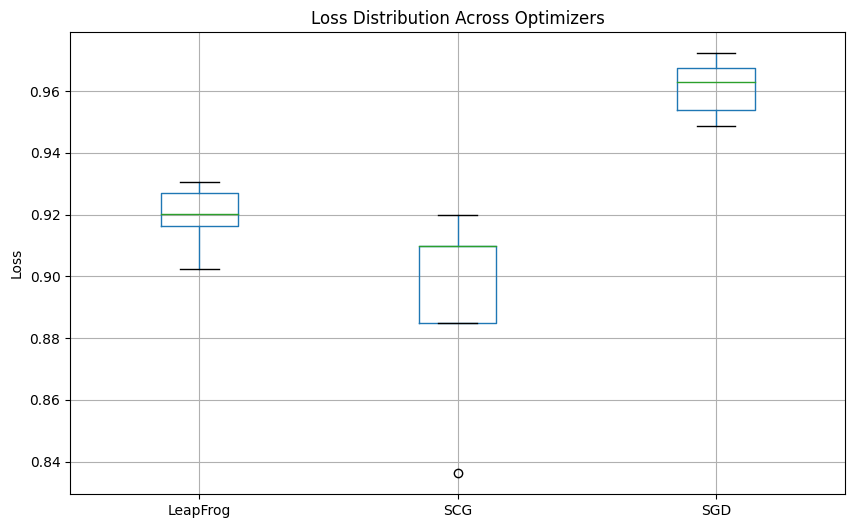

In [18]:
import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import matplotlib.pyplot as plt
from tabulate import tabulate  







loss_leapfrog = cross_val_df_leapFrog['val_accuracy'].values
loss_scg = cross_val_df_scg['val_accuracy'].values
loss_sgd = cross_val_df_sgd['test_accuracy'].values


combined_losses = pd.DataFrame({
    'LeapFrog': loss_leapfrog,
    'SCG': loss_scg,
    'SGD': loss_sgd
})


statistic, p_value = friedmanchisquare(
    combined_losses['LeapFrog'],
    combined_losses['SCG'],
    combined_losses['SGD']
)

print('Friedman test statistic:', statistic)
print('p-value:', p_value)

if p_value < 0.05:
    print('\nResult: There is a statistically significant difference between the optimizers.')

    
    nemenyi_results = sp.posthoc_nemenyi_friedman(combined_losses.values)

    
    optimizers = combined_losses.columns.tolist()
    nemenyi_results.columns = optimizers
    nemenyi_results.index = optimizers

    
    nemenyi_results = nemenyi_results.round(5)

    
    print('\nNemenyi post-hoc test p-values:')
    print(tabulate(nemenyi_results, headers='keys', tablefmt='grid'))

    
    print('\nInterpretation of the Table:')
    print('Diagonal Elements: The diagonal elements are all 1, as they represent comparisons of each optimizer with itself.\n')

    significant_pairs = []
    nonsignificant_pairs = []
    alpha = 0.05  

    
    for i in range(len(optimizers)):
        for j in range(i + 1, len(optimizers)):
            optimizer1 = optimizers[i]
            optimizer2 = optimizers[j]
            p_val = nemenyi_results.iloc[i, j]
            if p_val < alpha:
                significant_pairs.append((optimizer1, optimizer2, p_val))
            else:
                nonsignificant_pairs.append((optimizer1, optimizer2, p_val))

    
    if significant_pairs:
        print('Significant P-Values (p < 0.05):')
        for opt1, opt2, p_val in significant_pairs:
            print(f'- {opt1} vs. {opt2}: p = {p_val} (significant)')
    else:
        print('No significant differences found.')

    
    if nonsignificant_pairs:
        print('\nNon-Significant P-Values (p >= 0.05):')
        for opt1, opt2, p_val in nonsignificant_pairs:
            print(f'- {opt1} vs. {opt2}: p = {p_val} (not significant)')
    else:
        print('All pairs show significant differences.')

    
    plt.figure(figsize=(10, 6))
    combined_losses.boxplot()
    plt.ylabel('Loss')
    plt.title('Loss Distribution Across Optimizers')
    plt.grid(True)
    plt.show()

else:
    print('\nResult: There is no statistically significant difference between the optimizers.')


In [19]:
import numpy as np
import pandas as pd



mean_val_losses = np.array([
    cross_val_df_sgd['test_accuracy'].mean(),
    cross_val_df_scg['val_accuracy'].mean(),
    cross_val_df_leapFrog['val_accuracy'].mean()
])

mean_training_times = np.array([
    cross_val_df_sgd['training_time'].mean(),
    cross_val_df_scg['training_time'].mean(),
    cross_val_df_leapFrog['training_time'].mean()
])


norm_val_losses = (mean_val_losses - mean_val_losses.min()) / (mean_val_losses.max() - mean_val_losses.min())
norm_training_times = (mean_training_times - mean_training_times.min()) / (mean_training_times.max() - mean_training_times.min())


weight_val_loss = 0.6  
weight_time = 0.4      


combined_scores = weight_val_loss * norm_val_losses + weight_time * norm_training_times


algorithms = ['SGD', 'SCG', 'LeapFrog']

print("Mean CrossValidaiton Losses:")
for alg, loss in zip(algorithms, mean_val_losses):
    print(f"{alg}: {loss:.6f}")

print("\nMean Training Times (seconds):")
for alg, time_ in zip(algorithms, mean_training_times):
    print(f"{alg}: {time_:.6f}")

print("\nNormalized CrossValidaiton Losses:")
for alg, norm_loss in zip(algorithms, norm_val_losses):
    print(f"{alg}: {norm_loss:.6f}")

print("\nNormalized Training Times:")
for alg, norm_time in zip(algorithms, norm_training_times):
    print(f"{alg}: {norm_time:.6f}")

print("\nCombined Scores:")
for alg, score in zip(algorithms, combined_scores):
    print(f"{alg}: {score:.6f}")


preferred_index = np.argmin(combined_scores)
print(f"\nThe preferred algorithm considering both validation loss and time is: {algorithms[preferred_index]}")


Mean CrossValidaiton Losses:
SGD: 0.961029
SCG: 0.892112
LeapFrog: 0.919268

Mean Training Times (seconds):
SGD: 18.426880
SCG: 0.072093
LeapFrog: 0.145009

Normalized CrossValidaiton Losses:
SGD: 1.000000
SCG: 0.000000
LeapFrog: 0.394036

Normalized Training Times:
SGD: 1.000000
SCG: 0.000000
LeapFrog: 0.003973

Combined Scores:
SGD: 1.000000
SCG: 0.000000
LeapFrog: 0.238011

The preferred algorithm considering both validation loss and time is: SCG
